Задание по класстеризации: берете 3-4 класса из 20  NewsGroup и используете их для класстеризации по 3-4 класстерам. Полученные результаты сравниваете с теми, что должны были бы получить в идеале - использовать 2-3 разные внешние меры оценки качества.
Алгоритмы кластеризации: DBSCAN/HDBSCAN, K-means, Agglomerative clustering

## Data preprocessing

In [9]:
import warnings
import numpy as np
import re
import string
import nltk
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from tqdm.notebook import tqdm
from gensim import corpora, models
from nltk import pos_tag
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
warnings.filterwarnings("ignore")


In [10]:
from sklearn.datasets import fetch_20newsgroups
number_of_topic = 4
newsgroups_train = fetch_20newsgroups(subset='train')
indices = np.where((newsgroups_train.target >= 0) & (newsgroups_train.target < number_of_topic))[0]
texts = [newsgroups_train.data[i] for i in indices]
target = np.array([newsgroups_train.target[i] for i in indices])
print(f"Всего элементов: {target.shape[0]}")
for i in range(number_of_topic):
    count = np.count_nonzero(target == i)
    print(f"ко-во элементов из класса {i}: {count}")

Всего элементов: 2245
ко-во элементов из класса 0: 480
ко-во элементов из класса 1: 584
ко-во элементов из класса 2: 591
ко-во элементов из класса 3: 590


In [11]:
np.unique(target)

array([0, 1, 2, 3])

In [12]:
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens


def preprocess_text(text): 
    # Удаление пунктуации
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    
    tokens = [token for token in tokens if token not in stop_words]

    lemmatized_tokens = lemmatize_tokens(tokens)
    
    return " ".join(lemmatized_tokens)

In [13]:
corpus = [preprocess_text(i) for i in texts]
corpus[0][:60]

'From jgreenamber Joe Green Subject Re Weitek P9000 Organizat'

# Lsi

In [14]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
mini_size = 1680 #best size
lsi_model = TruncatedSVD(n_components=mini_size)
lsi_vectors = lsi_model.fit_transform(tfidf_matrix)

# LDA

In [15]:
def lda_repo(tokenized_corpus, num_topics=15):
    # Создание словаря
    dictionary = Dictionary(tokenized_corpus)
    
    # Преобразование текстов в мешок слов
    bow_corpus = [dictionary.doc2bow(text) for text in tokenized_corpus]
    
    # Обучение модели LDA
    lda_model = LdaModel(
        corpus=bow_corpus,  # Мешок слов
        id2word=dictionary,  # Словарь
        num_topics=num_topics,  # Количество тем
        passes=10,  # Количество итераций по корпусу
        iterations=100,  # Количество итераций для оценки параметров
        random_state=42  # Зафиксированный случайный seed для воспроизводимости результатов
    )
    return lda_model, bow_corpus

In [20]:
best_param = 10
lda_model, bow_corpus = lda_repo([text.split() for text in corpus], best_param)
# получаем тематические векторы
lda_vec = []
for i in tqdm(range(len(target))):
    doc_topics = lda_model.get_document_topics(bow_corpus[i])
    doc_vec = np.zeros(best_param)
    for topic, prob in doc_topics:
        #top_numb = int(re.sub(r'[a-zA-Z]', '', topic))
        doc_vec[topic] = prob
    lda_vec.append(doc_vec)

  0%|          | 0/2245 [00:00<?, ?it/s]

In [21]:
print('ready')

ready


# Bert

In [ ]:
#pip install transformers

In [22]:
import torch
from transformers import BertTokenizer, BertModel

In [23]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

In [24]:
tokenized_texts = [tokenizer(text, padding=True, truncation=True, return_tensors="pt") for text in corpus]
with torch.no_grad():
    outputs = [model(**i).last_hidden_state[:, 0, :] for i in tokenized_texts]
bert_vec = [output.squeeze() for output in outputs]

In [27]:
len(bert_vec), bert_vec[0].shape, target.shape

(2245, torch.Size([768]), (2245,))

# Tf_idf BoW

In [28]:
vectorizer = CountVectorizer()
BoWX = vectorizer.fit_transform(corpus).toarray()


In [29]:
vectorizer = TfidfVectorizer()
tf_idfX = vectorizer.fit_transform(corpus)

In [30]:
"ready"

'ready'

# Clastering

## K-Means Bert

- Всего элементов: 2245
- ко-во элементов из класса 0: 480
- ко-во элементов из класса 1: 584
- ко-во элементов из класса 2: 591
- ко-во элементов из класса 3: 590

In [34]:
from sklearn.cluster import KMeans

In [40]:
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

def print_metrics(y_true, y_pred):
    #y_true, y_pred = [0, 0, 1, 1, 2, 2], [0, 0, 1, 2, 2, 2]
    h_m_v = homogeneity_completeness_v_measure(y_true, y_pred)
    a_r_s = adjusted_rand_score(y_true, y_pred)
    a_m_i_s = adjusted_mutual_info_score(y_true, y_pred)
    print(f"homogeneity_completeness_v_measure: {h_m_v}")
    print(f"adjusted_rand_score: {a_r_s}")
    print(f"adjusted_mutual_info_score: {a_m_i_s}")


In [84]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def KMeans_model_cos(text_repr, number_of_topic=4, num_iterations=5):
    all_labels = []
    for _ in range(num_iterations):
        kmeans = KMeans(n_clusters=number_of_topic, init='k-means++', random_state=42)
        kmeans.fit(text_repr)

        centroids = kmeans.cluster_centers_
        cosine_distances = cosine_similarity(text_repr, centroids)   
        labels = np.argmax(cosine_distances, axis=1)
        all_labels.append(labels)

    avg_labels = np.mean(np.array(all_labels), axis=0)

    return avg_labels.astype(int)


In [85]:
def KMeans_model(text_repr, number_of_topic=4, num_iterations=5):
    all_labels = []
    for _ in range(num_iterations):
        kmeans = KMeans(n_clusters=number_of_topic, init='k-means++', random_state=42)
        kmeans.fit(text_repr) 
        labels = kmeans.labels_
        all_labels.append(labels)

    avg_labels = np.mean(np.array(all_labels), axis=0)
    return avg_labels.astype(int)


In [86]:
print("Распределение элементов по кластерам:")
labels = KMeans_model_cos(bert_vec)
labels_ev = KMeans_model(bert_vec)
print(np.bincount(labels))
print(np.bincount(labels_ev))

Распределение элементов по кластерам:
[1014  369  378  484]
[1012  368  380  485]


In [87]:
print_metrics(target, labels)

homogeneity_completeness_v_measure: (0.23042842098899674, 0.24764494462972522, 0.2387266794630251)
adjusted_rand_score: 0.17604177636124146
adjusted_mutual_info_score: 0.23757902300353387


In [90]:
print_metrics(target, labels_ev)

homogeneity_completeness_v_measure: (0.22951359238910624, 0.24651730028634178, 0.23771176217908724)
adjusted_rand_score: 0.17520669035662773
adjusted_mutual_info_score: 0.23656290357578563


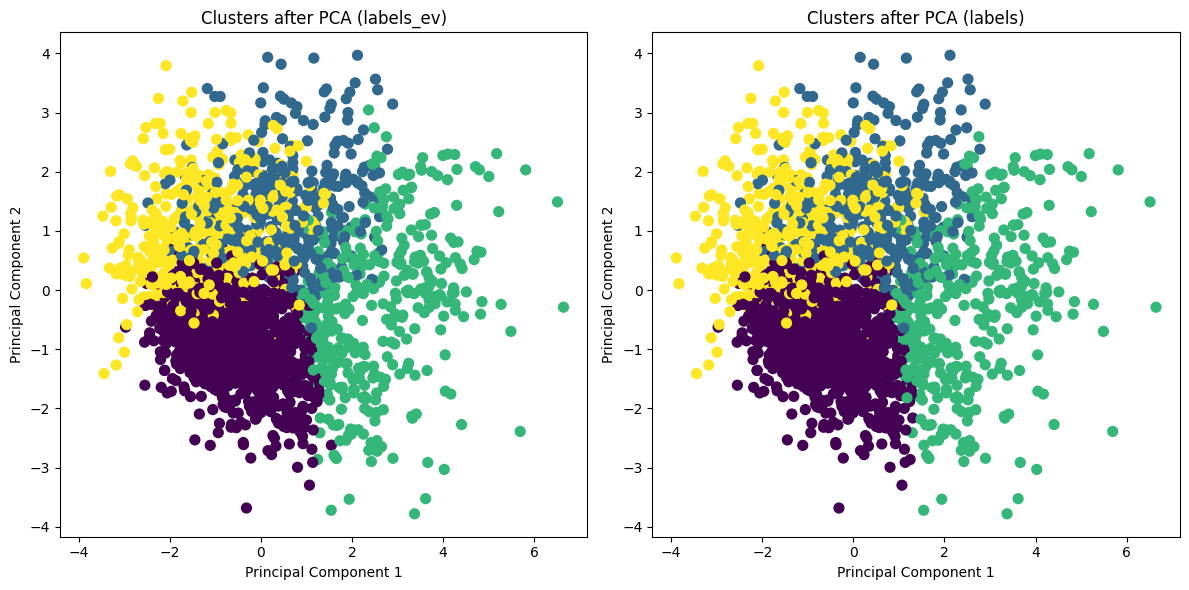

In [89]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Создание объекта PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(bert_vec)

# Разделение на два подграфика
plt.figure(figsize=(12, 6))

# Первый график с метками labels_ev
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_ev, cmap='viridis', marker='o', s=50)
plt.title('Clusters after PCA (labels_ev)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Второй график с метками labels
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.title('Clusters after PCA (labels)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Отображение графиков
plt.tight_layout()
plt.show()


--------

- ARI измеряет процент согласованных пар объектов между двумя разбиениями, относительно всех возможных пар объектов.

- $a$ — число пар объектов, имеющих одинаковые метки и находящихся в одном кластере, через $b$ — число пар объектов, имеющих различные метки и находящихся в разных кластерах.

$RI = \frac{2(a + b)}{n(n - 1)} \$

$ARI = \frac{RI - E[RI]}{max(RI) - E[RI]}\$

## Agglomerative clustering Bert

In [91]:
from sklearn.cluster import AgglomerativeClustering

agg_cluster = AgglomerativeClustering(n_clusters=4)

agg_cluster.fit(bert_vec)
labels = agg_cluster.labels_

print("Распределение элементов по кластерам:")
print(np.bincount(labels))


Распределение элементов по кластерам:
[1412  282  177  374]


In [92]:
print_metrics(target, labels)

homogeneity_completeness_v_measure: (0.22994781112981857, 0.30248879330117984, 0.2612766865840858)
adjusted_rand_score: 0.18333344186545167
adjusted_mutual_info_score: 0.2600536421426438


## DBSCAN bert

In [67]:
#pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 7.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
Using cached Cython-0.29.37-py2.py3-none-any.whl (989 kB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp39-cp39-macosx_10_9_universal2.whl size=1260300 sha256=e3c3f5f739f302621b5e6f62aed649e2801fa885f53179953d770246b8da349a
  Stored in directory: /Users/igorkopylov/Library/Caches/pip/wheels/28/5e/ed/5989da4cc423a222a47cbb4fde5d6c0eff4590d922e45f233c
Successfully built hdbscan
Note: you may need to restart the kernel to use updated packages.


- eps (epsilon): Это параметр, который определяет максимальное расстояние между двумя точками, чтобы они считались соседями. Если расстояние между точками меньше или равно eps, они считаются соседями. Этот параметр определяет радиус окрестности каждой точки.
- min_samples: Это параметр, который определяет минимальное количество точек, которые должны находиться в эпсилон-окрестности данной точки, чтобы она считалась основной точкой (core point)

In [126]:
from sklearn.cluster import DBSCAN
import hdbscan


dbscan = DBSCAN(eps=0.3, min_samples=10)  # Параметры eps и min_samples могут быть настроены в зависимости от данных
dbscan.fit(bert_vec)
labels = dbscan.labels_

In [127]:
labels[:5]

array([-1, -1, -1, -1, -1])

In [128]:
print_metrics(target, labels)

homogeneity_completeness_v_measure: (0.0, 1.0, 0.0)
adjusted_rand_score: 0.0
adjusted_mutual_info_score: 0.0


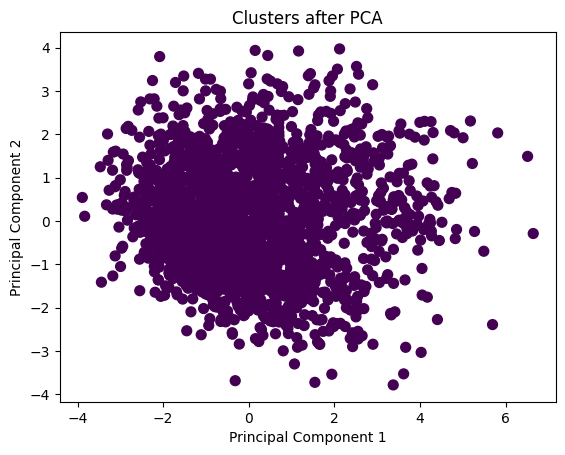

In [129]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(bert_vec)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.title('Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## K-Means LSI

In [96]:
from sklearn.cluster import KMeans
import numpy as np


labels = KMeans_model_cos(lsi_vectors)
labels_ev = KMeans_model(lsi_vectors)
print("Распределение элементов по кластерам:")
print(np.bincount(labels))

Распределение элементов по кластерам:
[   6 1739  466   34]


In [94]:
print_metrics(target, labels)

homogeneity_completeness_v_measure: (0.3558666285188645, 0.8153395855743834, 0.4954757683572588)
adjusted_rand_score: 0.272120767386854
adjusted_mutual_info_score: 0.49436987138260813


In [97]:
print_metrics(target, labels_ev)

homogeneity_completeness_v_measure: (0.3037185564673313, 0.7640876459996936, 0.43466238784039035)
adjusted_rand_score: 0.22726761682548305
adjusted_mutual_info_score: 0.43337079585678107


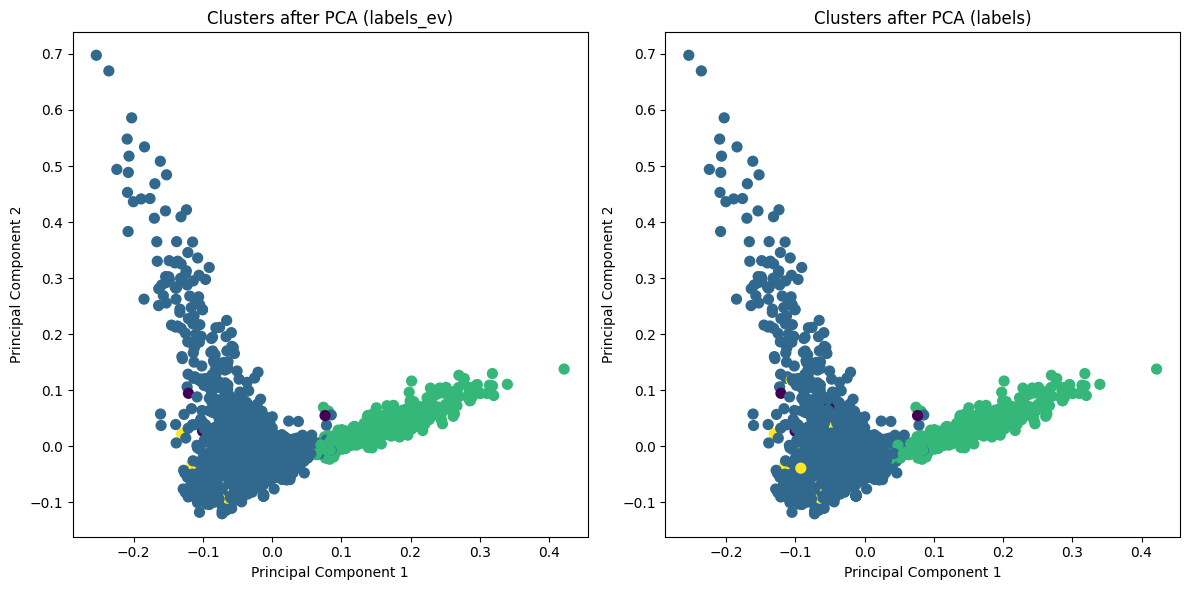

In [98]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Создание объекта PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(lsi_vectors)

# Разделение на два подграфика
plt.figure(figsize=(12, 6))

# Первый график с метками labels_ev
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_ev, cmap='viridis', marker='o', s=50)
plt.title('Clusters after PCA (labels_ev)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Второй график с метками labels
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.title('Clusters after PCA (labels)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Отображение графиков
plt.tight_layout()
plt.show()


## Agglomerative clustering LSI

In [99]:
agg_cluster = AgglomerativeClustering(n_clusters=4)

agg_cluster.fit(lsi_vectors)
labels = agg_cluster.labels_

print("Распределение элементов по кластерам:")
print(np.bincount(labels))


Распределение элементов по кластерам:
[ 469 1735   10   31]


In [100]:
print_metrics(target, labels)

homogeneity_completeness_v_measure: (0.36491866376232346, 0.8277910059496638, 0.5065380040702874)
adjusted_rand_score: 0.27586634670100346
adjusted_mutual_info_score: 0.5054853234378267


In [101]:
# rf

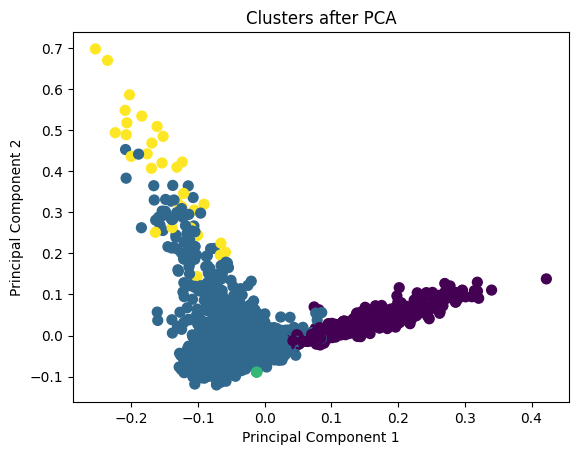

In [102]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(lsi_vectors)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.title('Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## DBSCAN LSI

In [103]:
from sklearn.cluster import DBSCAN
import hdbscan


dbscan = DBSCAN(eps=0.3, min_samples=2)  # Параметры eps и min_samples могут быть настроены в зависимости от данных
dbscan.fit(lsi_vectors)
labels = dbscan.labels_

In [104]:
print_metrics(target, labels)

homogeneity_completeness_v_measure: (0.04351762187882701, 0.16938303428646376, 0.06924494242088147)
adjusted_rand_score: -0.000646945182161549
adjusted_mutual_info_score: 0.02957601474527774


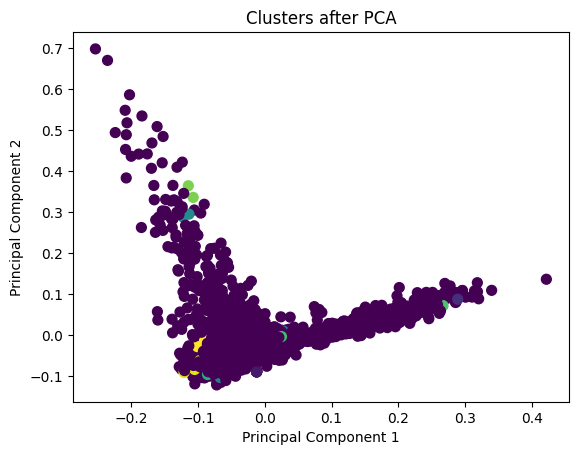

In [105]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(lsi_vectors)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.title('Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## K-Means Lda

In [106]:
kmeans = KMeans(n_clusters=number_of_topic)

kmeans.fit(lda_vec)
labels = kmeans.labels_

print("Распределение элементов по кластерам:")
print(np.bincount(labels))

Распределение элементов по кластерам:
[337 459 699 750]


In [107]:
print_metrics(target, labels)

homogeneity_completeness_v_measure: (0.1999374479516158, 0.2064896947958762, 0.20316075509477172)
adjusted_rand_score: 0.1416232622599988
adjusted_mutual_info_score: 0.20198274536531022


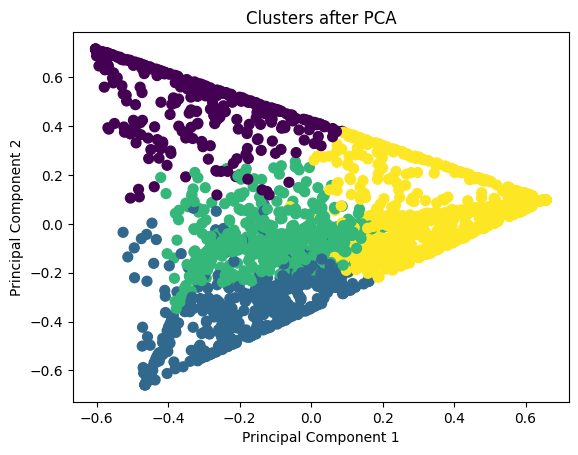

In [108]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(lda_vec)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.title('Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [109]:
agg_cluster = AgglomerativeClustering(n_clusters=4)

agg_cluster.fit(lda_vec)
labels = agg_cluster.labels_

print("Распределение элементов по кластерам:")
print(np.bincount(labels))


Распределение элементов по кластерам:
[693 582 622 348]


In [110]:
print_metrics(target, labels)

homogeneity_completeness_v_measure: (0.19252079388289073, 0.1961034787117063, 0.1942956221067451)
adjusted_rand_score: 0.1444341153207467
adjusted_mutual_info_score: 0.19311270000936562


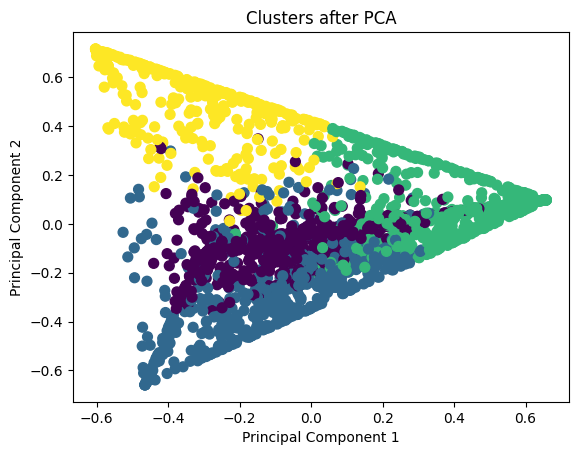

In [111]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(lda_vec)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.title('Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# BoW

In [112]:
kmeans = KMeans(n_clusters=number_of_topic)

kmeans.fit(BoWX)
labels = kmeans.labels_

print("Распределение элементов по кластерам:")
print(np.bincount(labels))

Распределение элементов по кластерам:
[2239    4    1    1]


In [113]:
print_metrics(target, labels)

homogeneity_completeness_v_measure: (0.00265138189806308, 0.17606219934252704, 0.005224092372045494)
adjusted_rand_score: -3.531693093935601e-05
adjusted_mutual_info_score: 0.0022870026038817885


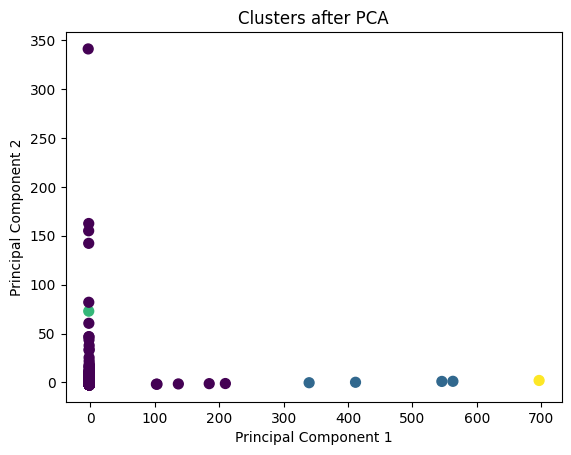

In [114]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(BoWX)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.title('Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [115]:
agg_cluster = AgglomerativeClustering(n_clusters=4)

agg_cluster.fit(BoWX)
labels = agg_cluster.labels_

print("Распределение элементов по кластерам:")
print(np.bincount(labels))


Распределение элементов по кластерам:
[  11    5 2224    5]


In [116]:
print_metrics(target, labels)

homogeneity_completeness_v_measure: (0.005459374069686785, 0.12063551455490318, 0.010446012637437356)
adjusted_rand_score: -4.7038879186478054e-05
adjusted_mutual_info_score: 0.0071375585716827615


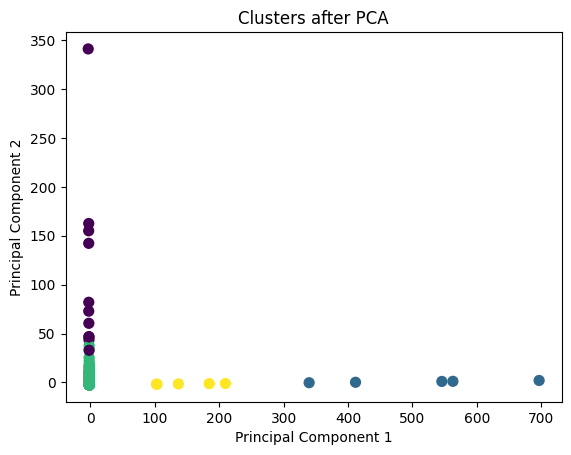

In [117]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(BoWX)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.title('Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()